# Non-trivial models analysis

Created 15/04/2025

Objectives:
* Investigate [these](./save_fermionic_models/save_fermionic_trivial_to_non_trivial_proj_rep_models.ipynb) [models](./save_fermionic_models/save_trivial_to_fermionic_non_trivial_models.ipynb).
* Check
    * Energies
    * Correlation lengths
    * Fermion occupation
    * Fermionic and proj rep cohomologies.

# Package imports

In [1]:
import sys
sys.path.append('../')

In [2]:
import h5py
from tenpy.tools import hdf5_io
import tenpy
import tenpy.linalg.np_conserved as npc

import os

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
from SPTOptimization.SymmetryActionWithBoundaryUnitaries import SymmetryActionWithBoundaryUnitaries

from SPTOptimization.utils import (
    to_npc_array,
    get_right_identity_environment,
    get_right_identity_environment_from_tp_tensor,
    multiply_stacked_unitaries_against_mps,
    inner_product_b_tensors
)

from SPTOptimization.Optimizers.MPSBrickSolver import(
    MPSBrickSolver
)

# Load data

In [5]:
DATA_DIR_1 = r"../data/interpolated_trivial_to_nontrivial_fermionic_trivial_proj_rep_200_site_dmrg/"
DATA_DIR_2 = r"../data/interpolated_nontrivial_fermionic_proj_rep_to_nontrivial_proj_rep_200_site_dmrg/"

In [6]:
def parse_file_name(file_name):
    interpolation = int(file_name.split('_')[0])/100

    return interpolation

In [20]:
loaded_data_triv_proj_rep = dict()
energies_triv_proj_rep = dict()

for local_file_name in list(os.walk(DATA_DIR_1))[0][2]:
    f_name = r"{}/{}".format(DATA_DIR_1, local_file_name, ignore_unknown=False)
    with h5py.File(f_name, 'r') as f:
        data = hdf5_io.load_from_hdf5(f)

        data_info = parse_file_name(local_file_name)
        loaded_data_triv_proj_rep[data_info]=data['wavefunction']
        energies_triv_proj_rep[data_info]=data['energy']

In [25]:
loaded_data_non_triv_proj_rep = dict()
energies_non_triv_proj_rep = dict()

for local_file_name in list(os.walk(DATA_DIR_2))[0][2]:
    f_name = r"{}/{}".format(DATA_DIR_2, local_file_name, ignore_unknown=False)

    with h5py.File(f_name, 'r') as f:
        data = hdf5_io.load_from_hdf5(f)

        data_info = parse_file_name(local_file_name)
        loaded_data_non_triv_proj_rep[data_info]=data['wavefunction']
        energies_non_triv_proj_rep[data_info]=data['energy']

# Definitons

In [26]:
MAX_VIRTUAL_BOND_DIM = 8
MAX_INTERMEDIATE_VIRTUAL_BOND_DIM = 2*MAX_VIRTUAL_BOND_DIM
# MPO bond dim?
MAX_MPO_BOND_DIM = 50

SVD_CUTOFF = 1e-3

Define bosonic symmetries. Label by the group element added.

In [27]:
np_00 = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])

np_01 = np.array([
    [0, 1, 0, 0],
    [1, 0, 0, 0],
    [0, 0, 0, 1],
    [0, 0, 1, 0]
])

np_10 = np.array([
    [0, 0, 1, 0],
    [0, 0, 0, 1],
    [1, 0, 0, 0],
    [0, 1, 0, 0]
])

np_11 = np.array([
    [0, 0, 0, 1],
    [0, 0, 1, 0],
    [0, 1, 0, 0],
    [1, 0, 0, 0]
])

In [28]:
bosonic_np_symmetries = [
    np_00,
    np_01,
    np_10,
    np_11
]

In [29]:
bosonic_npc_symmetries = [
    to_npc_array(X) for X in bosonic_np_symmetries
]

In [30]:
npc_00 = to_npc_array(np_00)
npc_01 = to_npc_array(np_01)
npc_10 = to_npc_array(np_10)
npc_11 = to_npc_array(np_11)

Define "fermionic symmetries". Just identity and JW string.

In [31]:
np_I = np.array([
    [1, 0],
    [0, 1]
])

np_JW = np.array([
    [1, 0],
    [0, -1]
])

In [32]:
fermionic_np_symmetries = [np_I, np_JW]

In [33]:
fermionic_npc_symmetries = [
    to_npc_array(X) for X in fermionic_np_symmetries
]

In [34]:
npc_JW = fermionic_npc_symmetries[1]

In [35]:
symmetry_actions = [
    [[b, f] for b in bosonic_np_symmetries]
    for f in fermionic_np_symmetries
]

In [36]:
shifted_symmetry_actions = [
    [[f, b] for b in bosonic_np_symmetries]
    for f in fermionic_np_symmetries
]

In [38]:
cases_triv_proj_rep = dict()

for k, psi in loaded_data_triv_proj_rep.items():

    for i, l in enumerate(symmetry_actions):

        for j, s in enumerate(l):
            case = SymmetryActionWithBoundaryUnitaries(
                psi,
                s*40,
                left_symmetry_index=60,
                left_boundary_unitaries=[np_I, np_00]*1,
                right_boundary_unitaries=[np_00, np_I]*1
            )

            cases_triv_proj_rep[(k, i, j)] = case

In [40]:
for c in cases_triv_proj_rep.values():
    c.compute_svd_approximate_expectation()

In [41]:
cases_non_triv_proj_rep = dict()

for k, psi in loaded_data_non_triv_proj_rep.items():

    for i, l in enumerate(symmetry_actions):

        for j, s in enumerate(l):
            case = SymmetryActionWithBoundaryUnitaries(
                psi,
                s*40,
                left_symmetry_index=60,
                left_boundary_unitaries=[np_I, np_00]*1,
                right_boundary_unitaries=[np_00, np_I]*1
            )

            cases_non_triv_proj_rep[(k, i, j)] = case

In [42]:
for c in cases_non_triv_proj_rep.values():
    c.compute_svd_approximate_expectation()

In [43]:
left_trivial_leg_charge = tenpy.linalg.charges.LegCharge(
    tenpy.linalg.charges.ChargeInfo([], []),
    [0,1],
    [[]],
    qconj=1
)

In [44]:
right_trivial_leg_charge = tenpy.linalg.charges.LegCharge(
    tenpy.linalg.charges.ChargeInfo([], []),
    [0,1],
    [[]],
    qconj=-1
)

# Analysis

## Energies

In [45]:
interpolation_values = sorted(list(energies_triv_proj_rep.keys()))

In [46]:
energies_triv_proj_rep_list = [energies_triv_proj_rep[k] for k in interpolation_values]

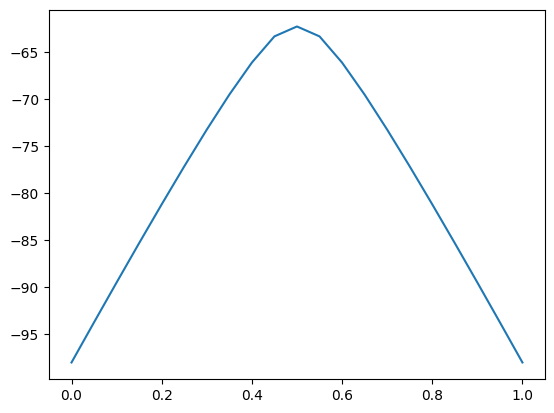

In [47]:
plt.plot(interpolation_values, energies_triv_proj_rep_list)

In [48]:
energies_non_triv_proj_rep_list = [energies_non_triv_proj_rep[k] for k in interpolation_values]

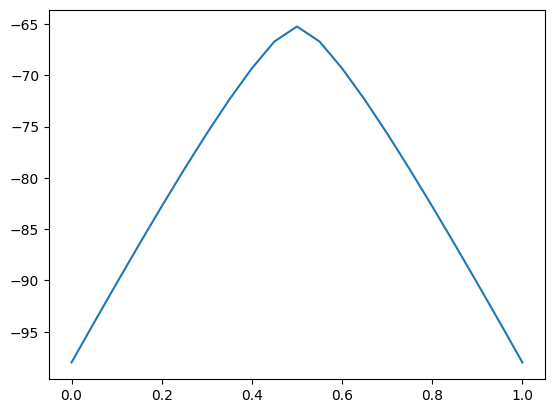

In [53]:
plt.plot(interpolation_values, energies_non_triv_proj_rep_list)

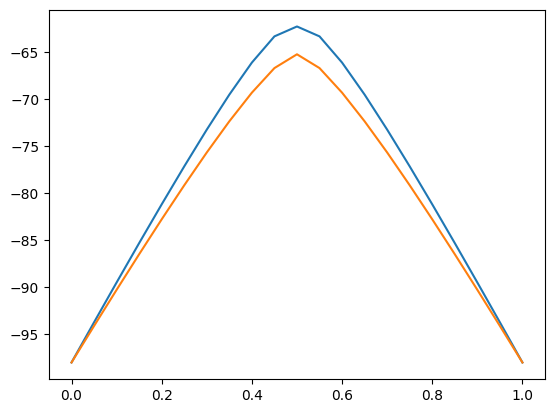

In [52]:
plt.plot(interpolation_values, energies_triv_proj_rep_list)
plt.plot(interpolation_values, energies_non_triv_proj_rep_list)

## Fermion occupation

In [54]:
fermion_occupation_triv_proj_rep = list()

for t in interpolation_values:
    psi = loaded_data_triv_proj_rep[t]
    out = psi.expectation_value('N', sites=[99,])[0]
    fermion_occupation_triv_proj_rep.append(out)

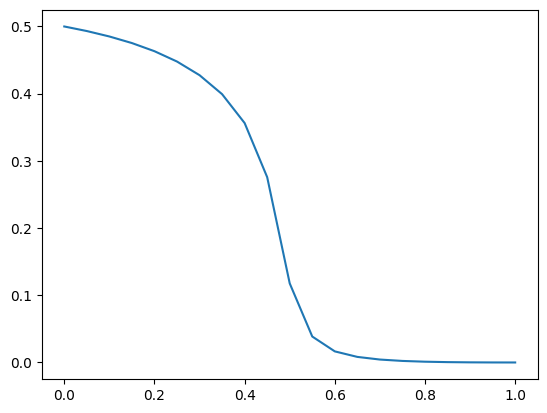

In [55]:
plt.plot(interpolation_values, fermion_occupation_triv_proj_rep)

In [56]:
fermion_occupation_non_triv_proj_rep = list()

for t in interpolation_values:
    psi = loaded_data_non_triv_proj_rep[t]
    out = psi.expectation_value('N', sites=[99,])[0]
    fermion_occupation_non_triv_proj_rep.append(out)

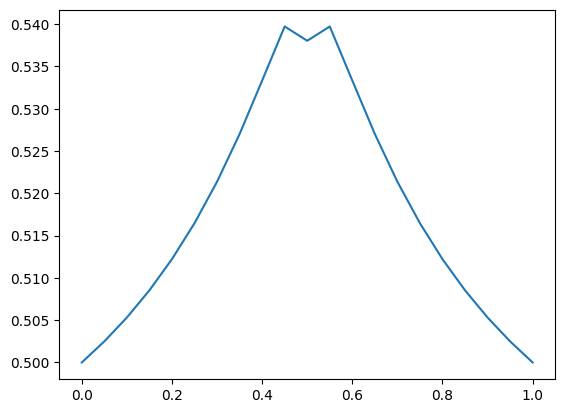

In [59]:
plt.plot(interpolation_values, fermion_occupation_non_triv_proj_rep)

# Sweep

In [32]:
block_width = 5
num_one_sided_iterations = 1
num_two_sided_iterations = 3
num_layers = 1
num_sites = 5

In [33]:
optimizer_dict = dict()

for k, v in cases.items():
    opt = MPSBrickSolver(
        v,
        num_sites,
        block_width,
        num_layers,
        num_one_sided_iterations,
        num_two_sided_iterations,
        max_virtual_bond_dim=MAX_VIRTUAL_BOND_DIM
    )

    opt.optimise()

    optimizer_dict[k] = opt

In [34]:
final_exps = dict()

for k, v in optimizer_dict.items():
    final_exp = v.flatten_exps()[-1]
    final_exps[k] = final_exp

In [35]:
bad_cases = [
    k
    for k, v in final_exps.items()
    if v < 0.99
]

In [36]:
bad_cases

[]

# Test proj rep

Give a wavefunction, calculate proj rep.

## SPT functions

In [37]:
def calculate_proj_rep_phase(state_g, left_schmidt_values_g, unitary_h,
                             state_gh,
                             left_environment,
                             max_virtual_bond_dim=MAX_VIRTUAL_BOND_DIM):
    prod_state, _ = multiply_stacked_unitaries_against_mps(
        unitary_h,
        state_g,
        left_schmidt_values_g,
        max_virtual_bond_dim
    )

    exp = inner_product_b_tensors(prod_state, state_gh, left_environment)

    return exp/(np.abs(exp))

In [38]:
def get_proj_rep_phases(mps_tensors, left_schmidt_values, unitaries,
                        left_environment):
    mps_dict = {
        k: v for k, v in zip(symmetry_labels[1:], mps_tensors)
    }

    schmidt_vals_dict = {
        k: v for k, v in zip(symmetry_labels[1:], left_schmidt_values)
    }

    unitaries_dict = {
        k: v for k, v in zip(symmetry_labels[1:], unitaries)
    }

    out_phases = list()

    for a, b, c in group_products:
        phase = calculate_proj_rep_phase(
            mps_dict[a],
            schmidt_vals_dict[a],
            unitaries_dict[b],
            mps_dict[c],
            left_environment,
            max_virtual_bond_dim=MAX_VIRTUAL_BOND_DIM
        )

        out_phases.append(phase)

    return out_phases

## Group data definitions

In [39]:
from itertools import combinations

In [40]:
symmetry_labels = [
    'II',
    'IX',
    'XI',
    'XX'
]

In [41]:
symmetry_combination_labels = list(combinations(symmetry_labels, 2))

In [42]:
symmetry_combination_labels

[('II', 'IX'),
 ('II', 'XI'),
 ('II', 'XX'),
 ('IX', 'XI'),
 ('IX', 'XX'),
 ('XI', 'XX')]

In [43]:
e, a, b, c = symmetry_labels

In [44]:
group_products = [
    (a, b, c),
    (b, a, c),
    (a, c, b),
    (c, a, b),
    (c, b, a),
    (b, c, a)
]

## Test case 1

In [45]:
proj_rep = True
n1_pair = (1, 0)

# May need to treat more consistently later.
jw_string = False

In [46]:
sub_opts = [
    optimizer_dict[(proj_rep, n1_pair, jw_string, i)]
    for i in range(4)
]

### Right side

In [47]:
test_opt = sub_opts[0]

In [48]:
mps_tensors = [
    opt.top_right_mps_tensors
    for opt in sub_opts
]

In [49]:
right_side_left_schmidt_values = [
    opt.current_right_side_left_schmidt_values
    for opt in sub_opts
]

In [50]:
unitaries = [
    opt.right_unitaries
    for opt in sub_opts
]

In [51]:
null_opt = optimizer_dict[(proj_rep, n1_pair, 0, 0)]

In [52]:
left_environment = null_opt.right_side_left_symmetry_environment

In [53]:
proj_rep_phases = get_proj_rep_phases(
    mps_tensors,
    right_side_left_schmidt_values,
    unitaries,
    left_environment
)

In [54]:
proj_rep_phases

[(-0.0043000789556949005+0.999990754617749j),
 (-0.09323234904908995+0.9956443788274952j),
 (-0.018756099265212108-0.9998240888978188j),
 (0.016460041777329598-0.9998645243355165j),
 (0.02414247646117309-0.9997085279371791j),
 (-0.011443915707803884+0.9999345162525759j)]

In [58]:
X = np.array(proj_rep_phases)

X[::2]/X[1::2]

array([ 0.99603608-0.08895014j,  0.99937991-0.0352107j ,
       -0.99991935-0.01270032j])

## Test case 2

In [55]:
proj_rep = True
n1_pair = (0, 0)

# May need to treat more consistently later.
jw_string = False

In [56]:
sub_opts = [
    optimizer_dict[(proj_rep, n1_pair, jw_string, i)]
    for i in range(4)
]

### Right side

In [57]:
test_opt = sub_opts[0]

In [58]:
mps_tensors = [
    opt.top_right_mps_tensors
    for opt in sub_opts
]

In [59]:
right_side_left_schmidt_values = [
    opt.current_right_side_left_schmidt_values
    for opt in sub_opts
]

In [60]:
unitaries = [
    opt.right_unitaries
    for opt in sub_opts
]

In [61]:
null_opt = optimizer_dict[(proj_rep, n1_pair, 0, 0)]

In [62]:
left_environment = null_opt.right_side_left_symmetry_environment

In [63]:
proj_rep_phases = get_proj_rep_phases(
    mps_tensors,
    right_side_left_schmidt_values,
    unitaries,
    left_environment
)

In [64]:
proj_rep_phases

[(1+0j), (1+0j), (1+0j), (1+0j), (1+0j), (1+0j)]

Better...! So why wrong when I have a non-trivial fermion homology?

## Test case 3

In [65]:
proj_rep = False
n1_pair = (1, 0)

# May need to treat more consistently later.
jw_string = False

In [66]:
sub_opts = [
    optimizer_dict[(proj_rep, n1_pair, jw_string, i)]
    for i in range(4)
]

### Right side

In [67]:
test_opt = sub_opts[0]

In [68]:
mps_tensors = [
    opt.top_right_mps_tensors
    for opt in sub_opts
]

In [69]:
right_side_left_schmidt_values = [
    opt.current_right_side_left_schmidt_values
    for opt in sub_opts
]

In [70]:
unitaries = [
    opt.right_unitaries
    for opt in sub_opts
]

In [71]:
null_opt = optimizer_dict[(proj_rep, n1_pair, 0, 0)]

In [72]:
left_environment = null_opt.right_side_left_symmetry_environment

In [73]:
proj_rep_phases = get_proj_rep_phases(
    mps_tensors,
    right_side_left_schmidt_values,
    unitaries,
    left_environment
)

In [74]:
proj_rep_phases

[(1+0j), (1+0j), (1+0j), (1+0j), (0.9999999999999999+0j), (1+0j)]

## Test case 4

In [75]:
proj_rep = False
n1_pair = (0, 0)

# May need to treat more consistently later.
jw_string = False

In [76]:
sub_opts = [
    optimizer_dict[(proj_rep, n1_pair, jw_string, i)]
    for i in range(4)
]

### Right side

In [77]:
test_opt = sub_opts[0]

In [78]:
mps_tensors = [
    opt.top_right_mps_tensors
    for opt in sub_opts
]

In [79]:
right_side_left_schmidt_values = [
    opt.current_right_side_left_schmidt_values
    for opt in sub_opts
]

In [80]:
unitaries = [
    opt.right_unitaries
    for opt in sub_opts
]

In [81]:
null_opt = optimizer_dict[(proj_rep, n1_pair, 0, 0)]

In [82]:
left_environment = null_opt.right_side_left_symmetry_environment

In [83]:
proj_rep_phases = get_proj_rep_phases(
    mps_tensors,
    right_side_left_schmidt_values,
    unitaries,
    left_environment
)

In [84]:
proj_rep_phases

[(1+0j), (1+0j), (1+0j), (1+0j), (1+0j), (1+0j)]

# String order parameters

In [85]:
np_Z_01 = np.array([
    [1, 0, 0, 0],
    [0, -1, 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, -1]
])

np_Z_10 = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, -1, 0],
    [0, 0, 0, -1]
])

np_Z_11 = np.array([
    [1, 0, 0, 0],
    [0, -1, 0, 0],
    [0, 0, -1, 0],
    [0, 0, 0, 1]
])

In [86]:
bosonic_np_phase_symmetries = [
    np_00,
    np_Z_01,
    np_Z_10,
    np_Z_11
]

In [87]:
bosonic_npc_phase_symmetries = [
    to_npc_array(X) for X in bosonic_np_phase_symmetries
]

In [88]:
npc_Z_01 = to_npc_array(np_Z_01)
npc_Z_10 = to_npc_array(np_Z_10)
npc_Z_11 = to_npc_array(np_Z_11)

In [89]:
fermion_identity = fermionic_npc_symmetries[0]

In [90]:
symmetry_term = [npc_01, fermion_identity]*50

In [91]:
string_order_term_1 = [npc_00, fermion_identity] + symmetry_term + [npc_00,]
string_order_term_2 = [npc_Z_01, fermion_identity] + symmetry_term + [npc_Z_01,]

In [92]:
string_order_params = dict()

n = 0

for l, v in loaded_data.items():
    for i, s in enumerate(bosonic_npc_symmetries):
        for j, b1 in enumerate(bosonic_npc_phase_symmetries):
            for k, b2 in enumerate(bosonic_npc_phase_symmetries):

                term = [b1, fermion_identity] + [s, fermion_identity]*5 + [b2,]
                exp = v.expectation_value_multi_sites(term, 50)

                string_order_params[(*l, i, j, k)] = exp
                n+=1

In [93]:
large_string_order_params = {
    k: v
    for k, v in string_order_params.items()
    if v > 0.1
}

In [94]:
large_string_order_params

{(False, (1, 1), 0, 0, 0): array(1.),
 (False, (1, 1), 3, 0, 0): array(1.),
 (False, (0, 0), 0, 0, 0): array(1.),
 (False, (0, 0), 1, 0, 0): array(1.),
 (False, (0, 0), 2, 0, 0): array(1.),
 (False, (0, 0), 3, 0, 0): array(1.),
 (True, (1, 0), 0, 0, 0): array(1.),
 (True, (0, 1), 0, 0, 0): array(1.),
 (True, (0, 0), 0, 0, 0): array(1.),
 (True, (1, 1), 0, 0, 0): array(1.),
 (False, (1, 0), 0, 0, 0): array(1.),
 (False, (1, 0), 2, 0, 0): array(1.),
 (False, (0, 1), 0, 0, 0): array(1.),
 (False, (0, 1), 1, 0, 0): array(1.)}

In [95]:
{
    k: v
    for k, v in large_string_order_params.items()
    if not k[0]
}

{(False, (1, 1), 0, 0, 0): array(1.),
 (False, (1, 1), 3, 0, 0): array(1.),
 (False, (0, 0), 0, 0, 0): array(1.),
 (False, (0, 0), 1, 0, 0): array(1.),
 (False, (0, 0), 2, 0, 0): array(1.),
 (False, (0, 0), 3, 0, 0): array(1.),
 (False, (1, 0), 0, 0, 0): array(1.),
 (False, (1, 0), 2, 0, 0): array(1.),
 (False, (0, 1), 0, 0, 0): array(1.),
 (False, (0, 1), 1, 0, 0): array(1.)}

In [96]:
np.all((-np_01 @ np_Z_01 @ np_01) == np_Z_01)

True

In [97]:
np.all((-np_10 @ np_Z_10 @ np_10) == np_Z_10)

True

In [98]:
np.all((np_11 @ np_Z_11 @ np_11) == np_Z_11)

True

In [99]:
np.all((-np_11 @ np_Z_10 @ np_11) == np_Z_10)

True

In [100]:
np.all((-np_11 @ np_Z_01 @ np_11) == np_Z_01)

True

In [101]:
np.all((np_01 @ np_Z_10 @ np_01) == np_Z_10)

True

In [102]:
np.all((np_10 @ np_Z_01 @ np_10) == np_Z_01)

True

In [103]:
string_order_params[(False, (0, 0), 1, 2, 2)]

array(1.57772181e-29)

In [104]:
string_order_params[(True, (0, 0), 1, 2, 2)]

array(-2.4713882e-28)

All looks good...

# Verify SPT phase with environments

In [65]:
def multiply_right_environments(env1, env2):
    out = npc.tensordot(
        env1,
        env2,
        [['vR',], ['vR*']]
    )

    return out

In [66]:
from functools import reduce

In [68]:
def normalise_scaled_unitary(matrix):
    m = matrix

    tr = npc.tensordot(
        m,
        m.conj(),
        [['vR', 'vR*'], ['vR*', 'vR']]
    )

    dim = m.to_ndarray().shape[0]

    scale = np.sqrt(tr/dim)

    out = m/scale

    return out

In [90]:
def right_proj_rep_invariant_phase_from_environments(case1, case2):
    v1 = case1.right_projected_symmetry_state
    v1 = normalise_scaled_unitary(v1)

    #print(np.round(npc.tensordot(v1, v1.conj(), [['vR',], ['vR*']]).to_ndarray()), 2)

    v2 = case2.right_projected_symmetry_state

    v2 = normalise_scaled_unitary(v2)

    #print(np.round(npc.tensordot(v2, v2.conj(), [['vR',], ['vR*']]).to_ndarray()), 2)

    t = reduce(
        multiply_right_environments,
        [v1, v2, v1.conj(), v2.conj()]
    )

    exp = npc.trace(t)
    phase = exp/np.abs(exp)

    return phase

In [96]:
def right_proj_rep_invariant_phases(cases):    
    case_pairs = list(combinations(cases[1:], 2))
    
    return [
        right_proj_rep_invariant_phase_from_environments_1(c1, c2)
        for c1, c2 in case_pairs
    ]

In [99]:
false_phases = dict()

for i in range(2):
    for j in range(2):
        for k in range(2):
            sub_cases = [
                cases[(False, (i, j), k, n)]
                for n in range(4)
            ]

            false_phases[((i,j), k)] = right_proj_rep_invariant_phases(sub_cases)

In [100]:
false_phases

{((0, 0), 0): [(1+0j), (1+0j), (1+0j)],
 ((0, 0), 1): [(1+0j), (1+0j), (1+0j)],
 ((0, 1), 0): [(1+0j), (1+0j), (1+0j)],
 ((0, 1), 1): [(-1+0j), (-1+0j), (1+0j)],
 ((1, 0), 0): [(1+0j), (1+0j), (1+0j)],
 ((1, 0), 1): [(-1+0j), (1+0j), (-1+0j)],
 ((1, 1), 0): [(1+0j), (1+0j), (1+0j)],
 ((1, 1), 1): [(1+0j), (-1+0j), (-1+0j)]}

So get oddities when I include JW string...

In [101]:
true_phases = dict()

for i in range(2):
    for j in range(2):
        for k in range(2):
            sub_cases = [
                cases[(True, (i, j), k, n)]
                for n in range(4)
            ]

            true_phases[((i,j), k)] = right_proj_rep_invariant_phases(sub_cases)

In [102]:
true_phases

{((0, 0), 0): [(-1-3.211485502404821e-17j),
  (-1-1.4039428900895112e-18j),
  (-1+9.918638682590741e-18j)],
 ((0, 0), 1): [(-1-3.211485502404821e-17j),
  (-1-1.4039428900895112e-18j),
  (-1+9.918638682590741e-18j)],
 ((0, 1), 0): [(-1-5.665342161500703e-17j),
  (-1-6.396157202863622e-17j),
  (-1-5.305445684341158e-17j)],
 ((0, 1), 1): [(1+2.4993389668172456e-18j),
  (1-2.634040531464544e-17j),
  (-1+2.6517082491055296e-17j)],
 ((1, 0), 0): [(-1-4.04441385285459e-17j),
  (-1-1.7830620530978122e-17j),
  (-1-4.1947414187852876e-17j)],
 ((1, 0), 1): [(1+4.657280249562082e-17j),
  (-1-7.179684026967964e-18j),
  (1+3.4219782756714087e-17j)],
 ((1, 1), 0): [(-1+2.2597038593027095e-17j),
  (-0.9999999999999999+1.8217293366854148e-17j),
  (-0.9999999999999999+1.5672224288459562e-17j)],
 ((1, 1), 1): [(-1+2.290518527880673e-17j),
  (1-2.878850530694425e-18j),
  (1-7.189137565000939e-18j)]}

In [103]:
def get_n1_func(n1_01, n1_10):
    l = [0, n1_01, n1_10, (n1_01 + n1_10)%2]
    
    def f(g1, g2):
        i = mod_4_to_bit_addition(g1, g2)
        return l[i]

    return f

In [109]:
def mod_4_to_bit(x):    
    possible_mod_4_values = list(range(4))
    assert x in possible_mod_4_values

    x0 = x % 2
    x1 = ((x - x0) // 2) % 2

    return (x0, x1)

In [110]:
def bit_to_mod_4(bit_pair):
    x0, x1 = bit_pair

    possible_mod_2_values = list(range(2))
    assert x0 in possible_mod_2_values
    assert x1 in possible_mod_2_values

    return x0 + 2*x1

In [111]:
def mod_4_to_bit_addition(x, y):
    (x0, x1) = mod_4_to_bit(x)
    (y0, y1) = mod_4_to_bit(y)

    out0 = (x0 + y0) % 2
    out1 = (x1 + y1) % 2

    out = bit_to_mod_4((out0, out1))

    return out

In [112]:
correct_jw_cases = dict()

for b in [True, False]:
    for i in range(2):
        for j in range(2):
            n1_func = get_n1_func(i, j)
            for k in range(4):
                jw_needed = n1_func(k, 0)

                correct_jw_cases[(b, (i,j), k)] = cases[(b, (i,j), jw_needed, k)]

In [113]:
false_phases = dict()

for i in range(2):
    for j in range(2):
            sub_cases = [
                correct_jw_cases[(False, (i, j), n)]
                for n in range(4)
            ]

            false_phases[(i,j)] = right_proj_rep_invariant_phases(sub_cases)

In [114]:
false_phases

{(0, 0): [(1+0j), (1+0j), (1+0j)],
 (0, 1): [(1+0j), (1+0j), (1+0j)],
 (1, 0): [(1+0j), (1+0j), (1+0j)],
 (1, 1): [(1+0j), (1+0j), (1+0j)]}

In [115]:
true_phases = dict()

for i in range(2):
    for j in range(2):
            sub_cases = [
                correct_jw_cases[(True, (i, j), n)]
                for n in range(4)
            ]

            true_phases[(i,j)] = right_proj_rep_invariant_phases(sub_cases)

In [116]:
true_phases

{(0, 0): [(-1-3.211485502404821e-17j),
  (-1-1.4039428900895112e-18j),
  (-1+9.918638682590741e-18j)],
 (0, 1): [(-1-5.891319278802497e-17j),
  (-1-1.2199597802845033e-17j),
  (-1+2.6517082491055296e-17j)],
 (1, 0): [(-1-8.17991323961216e-18j),
  (-1-7.179684026967964e-18j),
  (-1-2.725165914162097e-17j)],
 (1, 1): [(-1+2.290518527880673e-17j),
  (-1+3.2986681939795926e-17j),
  (-1+1.60635799401136e-17j)]}

In [84]:
test_cases = [
    cases[True, (0, 0), 0, i]
    for i in range(4)
]

case_pairs = list(combinations(test_cases[1:], 2))

[
    right_proj_rep_invariant_phase_from_environments_1(c1, c2)
    for c1, c2 in case_pairs
]

[(-1-3.211485502404821e-17j),
 (-1-1.4039428900895112e-18j),
 (-1+9.918638682590741e-18j)]

In [85]:
test_cases = [
    cases[False, (0, 0), 0, i]
    for i in range(4)
]

case_pairs = list(combinations(test_cases[1:], 2))

[
    right_proj_rep_invariant_phase_from_environments_1(c1, c2)
    for c1, c2 in case_pairs
]

[(1+0j), (1+0j), (1+0j)]

In [86]:
test_cases = [
    cases[True, (1, 0), 0, i]
    for i in range(4)
]

case_pairs = list(combinations(test_cases[1:], 2))

[
    right_proj_rep_invariant_phase_from_environments_1(c1, c2)
    for c1, c2 in case_pairs
]

[(-1-4.04441385285459e-17j),
 (-1-1.7830620530978122e-17j),
 (-1-4.1947414187852876e-17j)]

In [87]:
test_cases = [
    shifted_cases[True, (0, 0), 0, i]
    for i in range(4)
]

case_pairs = list(combinations(test_cases[1:], 2))

[
    right_proj_rep_invariant_phase_from_environments_1(c1, c2)
    for c1, c2 in case_pairs
]

[(-1+1.0614230926271299e-17j),
 (-1-2.5893412118385122e-17j),
 (-1+5.88079958047669e-17j)]

In [88]:
test_cases = [
    shifted_cases[False, (0, 0), 0, i]
    for i in range(4)
]

case_pairs = list(combinations(test_cases[1:], 2))

[
    right_proj_rep_invariant_phase_from_environments_1(c1, c2)
    for c1, c2 in case_pairs
]

[(1+0j), (1+0j), (1+0j)]

In [89]:
test_cases = [
    shifted_cases[True, (1, 0), 0, i]
    for i in range(4)
]

case_pairs = list(combinations(test_cases[1:], 2))

[
    right_proj_rep_invariant_phase_from_environments_1(c1, c2)
    for c1, c2 in case_pairs
]

[(-1+1.7317111592783285e-17j),
 (-1+6.103590476690632e-18j),
 (-1-6.011832065537458e-17j)]

# Check entanglement spectrum

In [59]:
for k, v in loaded_data.items():
    print(f"{k} - {v.get_SR(21)}")

(False, (1, 1)) - [0.70710678 0.70710678]
(True, (1, 1)) - [0.61237244 0.61237244 0.35355339 0.35355339]
(True, (0, 1)) - [0.61237244 0.61237244 0.35355339 0.35355339]
(False, (0, 1)) - [0.70710678 0.70710678]
(False, (1, 0)) - [0.70710678 0.70710678]
(True, (1, 0)) - [0.61237244 0.61237244 0.35355339 0.35355339]
(True, (0, 0)) - [0.6830127 0.6830127 0.1830127 0.1830127]
(False, (0, 0)) - [1.]


In [60]:
for k, v in loaded_data.items():
    print(f"{k} - {v.get_SR(20)}")

(False, (1, 1)) - [0.70710678 0.70710678]
(True, (1, 1)) - [0.61237244 0.61237244 0.35355339 0.35355339]
(True, (0, 1)) - [0.61237244 0.61237244 0.35355339 0.35355339]
(False, (0, 1)) - [0.70710678 0.70710678]
(False, (1, 0)) - [0.70710678 0.70710678]
(True, (1, 0)) - [0.61237244 0.61237244 0.35355339 0.35355339]
(True, (0, 0)) - [0.6830127 0.6830127 0.1830127 0.1830127]
(False, (0, 0)) - [1.]


So there is something going on... The 2-fold degeneracy due to the fermion spt is unexpected for me.

# To-do:
Calculate string order parameters.